<a href="https://colab.research.google.com/github/nicoleolivetto/CNN/blob/main/Copy_2_of_covid_data_reconstruction_with_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

In [41]:
covid_ds =pd.read_csv("covid_ds.csv")
covid_ds

,Unnamed: 0,Date,Region_code,Region_name,latitude,longitude,hospitalized_with_symptoms,intensive_care_petients,total_hospitalized_patients,home_isolation,current_positive_cases,change_in_total_positives,new_positive_cases,recovered,deceased,total_cases,tests_performed
0,0,2020-02-24T18:00:00,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5
1,1,2020-02-24T18:00:00,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0
2,2,2020-02-24T18:00:00,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,0,1
3,3,2020-02-24T18:00:00,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,0,10
4,4,2020-02-24T18:00:00,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,0,18,0,0,18,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,1717,2020-05-15T17:00:00,19,Sicilia,38.115697,13.362357,198,11,209,1551,1760,-94,8,1351,263,3374,112929
1718,1718,2020-05-15T17:00:00,9,Toscana,43.769231,11.255889,238,67,305,2863,3168,-220,24,5739,976,9883,197365
1719,1719,2020-05-15T17:00:00,10,Umbria,43.106758,12.388247,25,2,27,63,90,-2,2,1259,73,1422,53801
1720,1720,2020-05-15T17:00:00,2,Valle d'Aosta,45.737503,7.320149,37,0,37,40,77,-3,6,953,142,1172,11413


Preprocessing


In [42]:
# Convert 'Date' to datetime
covid_ds['Date'] = pd.to_datetime(covid_ds['Date'])

# Normalize numeric columns
numeric_columns = ['latitude', 'longitude', 'hospitalized_with_symptoms', 'intensive_care_petients',
                    'total_hospitalized_patients', 'home_isolation', 'current_positive_cases',
                    'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases',
                    'tests_performed']


scaler = MinMaxScaler()
covid_ds[numeric_columns] = scaler.fit_transform(covid_ds[numeric_columns])

# One-hot encode 'Region_name'
covid_ds = pd.get_dummies(covid_ds, columns=['Region_name'])


In [43]:
# Print summary statistics of numeric columns after normalization
print("Summary Statistics After Normalization:")
print(covid_ds[numeric_columns].describe())

Summary Statistics After Normalization:
          latitude    longitude  hospitalized_with_symptoms  \
count  1722.000000  1722.000000                 1722.000000   
mean      0.588121     0.513847                    0.066504   
std       0.296948     0.278586                    0.151006   
min       0.000000     0.000000                    0.000000   
25%       0.359021     0.398135                    0.003726   
50%       0.656167     0.530846                    0.014118   
75%       0.873035     0.675379                    0.053552   
max       1.000000     1.000000                    1.000000   

       intensive_care_petients  total_hospitalized_patients  home_isolation  \
count              1722.000000                  1722.000000     1722.000000   
mean                  0.071085                     0.067628        0.071551   
std                   0.140784                     0.150991        0.139678   
min                   0.000000                     0.000000        0.000000 

In [44]:
print(covid_ds[numeric_columns])

      latitude  longitude  hospitalized_with_symptoms  \
0     0.505213   0.636656                    0.000000   
1     0.301036   0.888741                    0.000000   
2     0.094264   0.971409                    0.000000   
3     0.324903   0.725939                    0.000000   
4     0.760848   0.421230                    0.000828   
...        ...        ...                         ...   
1717  0.000000   0.632876                    0.016395   
1718  0.674353   0.412239                    0.019707   
1719  0.595334   0.530846                    0.002070   
1720  0.909129   0.000000                    0.003064   
1721  0.873035   0.525630                    0.025751   

      intensive_care_petients  total_hospitalized_patients  home_isolation  \
0                    0.000000                     0.000000        0.000000   
1                    0.000000                     0.000000        0.000000   
2                    0.000000                     0.000000        0.000000   
3  

In [45]:
# 'selected_regions' contains the region codes you want to learn from (Northern Italy)
selected_regions = [8, 6, 7, 3, 1, 2, 5, 21, 22]

# Select data for the autoencoder from specified regions
autoencoder_data = covid_ds[covid_ds['Region_code'].isin(selected_regions)]

# Select data for evaluation from other regions
other_regions_data = covid_ds[~covid_ds['Region_code'].isin(selected_regions)]

# Columns relevant for the autoencoder
autoencoder_columns = ['hospitalized_with_symptoms', 'intensive_care_petients', 'total_hospitalized_patients', 'home_isolation', 'current_positive_cases', 'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases', 'tests_performed']

# Extract the relevant columns for training and evaluation
train_data = autoencoder_data[autoencoder_columns].values
test_data = other_regions_data[autoencoder_columns].values

# Print the shapes of the training and test sets
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


Train Data Shape: (738, 11)
Test Data Shape: (984, 11)


LSTM

In [46]:
sequence_length = 50
num_features = len(autoencoder_columns)

# Create sequences for training
def create_sequences(data, time_steps=sequence_length):
    Xs, ys = [], []
    for i in range(len(data) - time_steps + 1):
        Xs.append(data[i:(i + time_steps)])
        ys.append(data[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

# Assuming `train_data` and `test_data` are already defined
train_data_sequence, _ = create_sequences(train_data)
test_data_sequence, _ = create_sequences(test_data)

In [47]:
from tensorflow.keras.layers import Dropout
# Define the autoencoder model
input_shape = (sequence_length, num_features)
model = tf.keras.Sequential()

# Encoder
model.add(LSTM(64, activation='relu', input_shape=input_shape, return_sequences=False))
model.add(RepeatVector(sequence_length))

# Decoder
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(num_features, activation='sigmoid')))

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                19456     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 50, 64)            0         
 tor)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 50, 64)            33024     
                                                                 
 time_distributed_1 (TimeDi  (None, 50, 11)            715       
 stributed)                                                      
                                                                 
Total params: 53195 (207.79 KB)
Trainable params: 53195 (207.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# Train the autoencoder
history = model.fit(train_data_sequence, train_data_sequence, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/100
20/20 [==============================] - 7s 195ms/step - loss: 0.3756 - val_loss: 0.3105
Epoch 2/100
20/20 [==============================] - 2s 119ms/step - loss: 0.2317 - val_loss: 0.2405
Epoch 3/100
20/20 [==============================] - 2s 122ms/step - loss: 0.1883 - val_loss: 0.2233
Epoch 4/100
20/20 [==============================] - 2s 122ms/step - loss: 0.1904 - val_loss: 0.2439
Epoch 5/100
20/20 [==============================] - 7s 365ms/step - loss: 0.1882 - val_loss: 0.2232
Epoch 6/100
20/20 [==============================] - 2s 120ms/step - loss: 0.1745 - val_loss: 0.2220
Epoch 7/100
20/20 [==============================] - 2s 121ms/step - loss: 0.1745 - val_loss: 0.2220
Epoch 8/100
20/20 [==============================] - 2s 119ms/step - loss: 0.1746 - val_loss: 0.2219
Epoch 9/100
20/20 [==============================] - 4s 195ms/step - loss: 0.1747 - val_loss: 0.2219
Epoch 10/100
20/20 [==============================] - 3s 125ms/step - loss: 0.1747 - val_lo

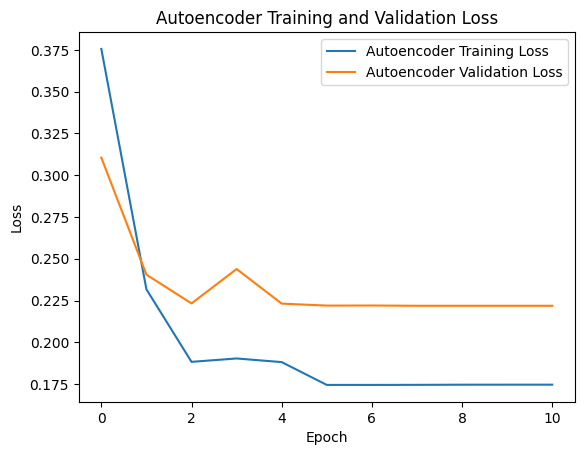

In [49]:
import matplotlib.pyplot as plt

# Plot training and validation loss for the autoencoder
plt.plot(history.history['loss'], label='Autoencoder Training Loss')
plt.plot(history.history['val_loss'], label='Autoencoder Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.show()

In [50]:
# Predict on test data
reconstructed_data_sequence = model.predict(test_data_sequence)


30/30 [==============================] - 1s 18ms/step


In [51]:
# Calculate reconstruction error for each sequence
mae_loss_autoencoder = np.mean(np.abs(reconstructed_data_sequence - test_data_sequence), axis=(1, 2))


In [75]:
len(mae_loss_autoencoder)

935

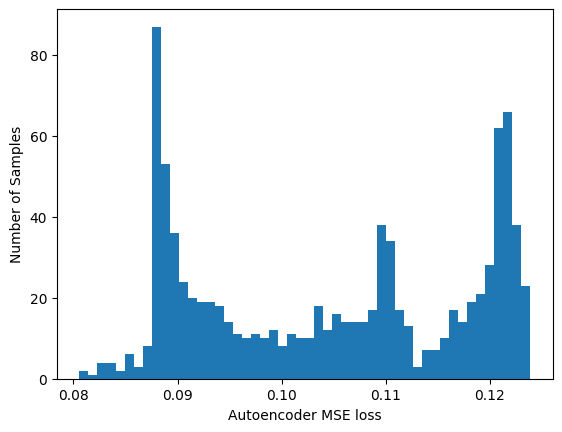

In [53]:
# Visualize the reconstruction errors
plt.hist(mae_loss_autoencoder, bins=50)
plt.xlabel('Autoencoder MSE loss')
plt.ylabel('Number of Samples')
threshold_autoencoder = np.percentile(mae_loss_autoencoder, 90)

In [54]:
print(f'Autoencoder reconstruction error threshold: {threshold_autoencoder}')

Autoencoder reconstruction error threshold: 0.12178770585574922


In [74]:
print(len(test_data))

984


In [77]:
score_df_autoencoder = pd.DataFrame(test_data[sequence_length:], columns=autoencoder_columns)
score_df_autoencoder.reset_index(drop=True, inplace=True)  # Resetting the index
score_df_autoencoder['loss_autoencoder'] = mae_loss_autoencoder[:len(score_df_autoencoder)]
score_df_autoencoder['threshold_autoencoder'] = threshold_autoencoder
score_df_autoencoder['anomaly_autoencoder'] = score_df_autoencoder['loss_autoencoder'] > score_df_autoencoder['threshold_autoencoder']


In [85]:
len(score_df_autoencoder)

934

In [79]:
# Extract the region codes for the regions in test_data
test_region_codes = other_regions_data['Region_code'].values

# Find the indexes of these region codes in the original dataset
original_indexes = covid_ds[covid_ds['Region_code'].isin(test_region_codes)].index

# Print the original indexes
print("Original Indexes of Test Regions:", original_indexes)


Original Indexes of Test Regions: Int64Index([   0,    1,    2,    3,    6,    9,   10,   14,   15,   16,
            ...
            1703, 1704, 1707, 1710, 1711, 1715, 1716, 1717, 1718, 1719],
           dtype='int64', length=984)


In [87]:
# Extract the region codes for the regions in test_data
test_region_codes = other_regions_data['Region_code'].values

# Find the indexes of these region codes in the original dataset
original_indexes = covid_ds[covid_ds['Region_code'].isin(test_region_codes)].index

# Create datasets with Date and Region_code values added
test_data_with_dates = other_regions_data.loc[other_regions_data.index.isin(original_indexes), autoencoder_columns + ['Date', 'Region_code']].copy()

# Add Date values to the datasets using the original indexes
test_data_with_dates['Date'] = covid_ds.loc[original_indexes, 'Date'].values

# Add Region_code values to the datasets using the original indexes
test_data_with_dates['Region_code'] = covid_ds.loc[original_indexes, 'Region_code'].values


# Create DataFrame for autoencoder information
score_df_autoencoder = pd.DataFrame(test_data[sequence_length:], columns=autoencoder_columns)
score_df_autoencoder['Date'] = test_data_with_dates['Date'].values
score_df_autoencoder['Region_code'] = test_data_with_dates['Region_code'].values
score_df_autoencoder['loss_autoencoder'] = mae_loss_autoencoder

# Calculate and add the threshold
threshold_autoencoder = np.percentile(mae_loss_autoencoder, 90)
score_df_autoencoder['threshold_autoencoder'] = threshold_autoencoder

# Identify anomalies based on the threshold
score_df_autoencoder['anomaly_autoencoder'] = score_df_autoencoder['loss_autoencoder'] > score_df_autoencoder['threshold_autoencoder']

# Print or use the DataFrame as needed
print("Score DataFrame with Autoencoder Information:")
print(score_df_autoencoder)


ValueError: Length of values (984) does not match length of index (934)

In [52]:
# Set threshold for anomaly detection (e.g., 90th percentile)
threshold_autoencoder = np.percentile(mae_loss_autoencoder, 90)

In [32]:


# Create a DataFrame with the appropriate index
autoencoder_loss_df = pd.DataFrame(index=autoencoder_data.index[:len(mae_loss_autoencoder)])
autoencoder_loss_df['autoencoder_loss'] = mae_loss_autoencoder
autoencoder_loss_df['threshold'] = threshold_autoencoder
autoencoder_loss_df['autoencoder_anomaly'] = autoencoder_loss_df['autoencoder_loss'] > autoencoder_loss_df['threshold']

# Merge with the original autoencoder_data DataFrame
autoencoder_data = pd.concat([autoencoder_data, autoencoder_loss_df], axis=1)


In [33]:
# Print the relevant columns
print(autoencoder_data[['Date', 'Region_code', 'autoencoder_loss', 'autoencoder_anomaly']])

                    Date  Region_code  autoencoder_loss  autoencoder_loss  \
4    2020-02-24 18:00:00            8          0.035350          0.035350   
5    2020-02-24 18:00:00            6          0.035236          0.035236   
7    2020-02-24 18:00:00            7          0.035143          0.035143   
8    2020-02-24 18:00:00            3          0.035072          0.035072   
11   2020-02-24 18:00:00           21          0.035047          0.035047   
...                  ...          ...               ...               ...   
1712 2020-05-15 17:00:00           21               NaN               NaN   
1713 2020-05-15 17:00:00           22               NaN               NaN   
1714 2020-05-15 17:00:00            1               NaN               NaN   
1720 2020-05-15 17:00:00            2               NaN               NaN   
1721 2020-05-15 17:00:00            5               NaN               NaN   

     autoencoder_anomaly  
4                  False  
5                  Fa

<ipython-input-33-c62b3852f2d6>:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  print(autoencoder_data[['Date', 'Region_code', 'autoencoder_loss', 'autoencoder_anomaly']])


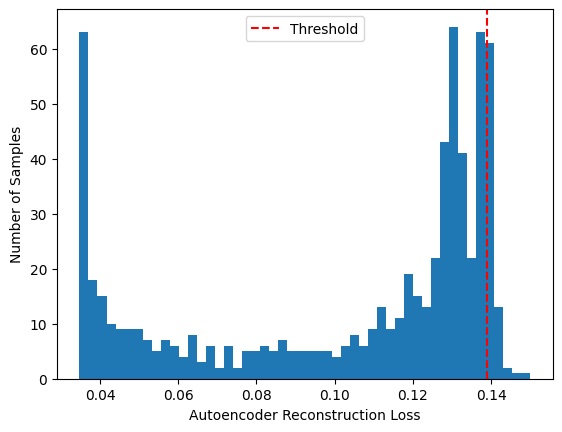

In [31]:
# Visualize the reconstruction error and anomalies
plt.hist(mae_loss_autoencoder, bins=50)
plt.xlabel('Autoencoder Reconstruction Loss')
plt.ylabel('Number of Samples')
plt.axvline(x=threshold_autoencoder, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [29]:
print(autoencoder_data)

      Unnamed: 0                Date  Region_code  latitude  longitude  \
4              4 2020-02-24 18:00:00            8  0.760848   0.421230   
5              5 2020-02-24 18:00:00            6  0.898624   0.675379   
7              7 2020-02-24 18:00:00            7  0.750962   0.168903   
8              8 2020-02-24 18:00:00            3  0.876839   0.195889   
11            11 2020-02-24 18:00:00           21  1.000000   0.422791   
...          ...                 ...          ...       ...        ...   
1712        1712 2020-05-15 17:00:00           21  1.000000   0.422791   
1713        1713 2020-05-15 17:00:00           22  0.948662   0.398135   
1714        1714 2020-05-15 17:00:00            1  0.829900   0.037764   
1720        1720 2020-05-15 17:00:00            2  0.909129   0.000000   
1721        1721 2020-05-15 17:00:00            5  0.873035   0.525630   

      hospitalized_with_symptoms  intensive_care_petients  \
4                       0.000828                 0

<ipython-input-29-03cafb6d457a>:1: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  print(autoencoder_data)


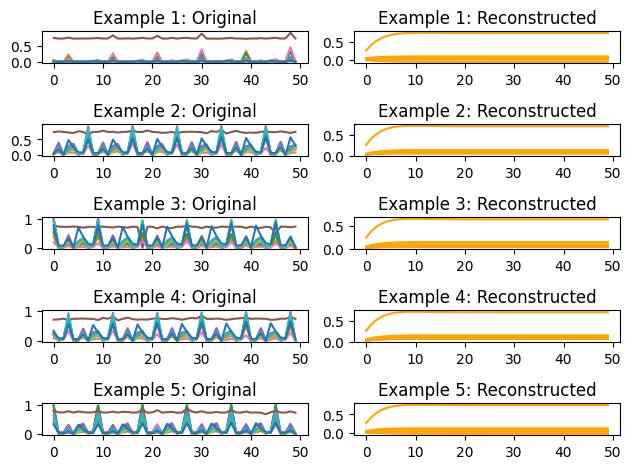

In [36]:
# Choose a few random examples for visualization
num_examples = 5
examples_indices = np.random.choice(len(X_autoencoder), num_examples, replace=False)

# Plot original and reconstructed data
for i, example_index in enumerate(examples_indices, 1):
    plt.subplot(num_examples, 2, 2 * i - 1)
    plt.plot(X_autoencoder[example_index], label='Original')
    plt.title(f'Example {i}: Original')
    #plt.legend()

    plt.subplot(num_examples, 2, 2 * i)
    plt.plot(X_autoencoder_pred[example_index], label='Reconstructed', color='orange')
    plt.title(f'Example {i}: Reconstructed')
    #plt.legend()

plt.tight_layout()
plt.show()

In [39]:
# Choose the region code to focus on
region_code_to_plot = 12

# Filter the datasets for the specific region
test_data_region = df[df['Region_code'] == region_code_to_plot]
reconstructed_data_region = pd.DataFrame(X_autoencoder_pred, columns=df.columns)[df['Region_code'] == region_code_to_plot]

# Specify the columns to plot
columns_to_plot = ['overall_score']  # Adjust this based on your columns

# Create a figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot original and reconstructed data
ax1.plot(test_data_region['Date'], test_data_region[columns_to_plot[0]], label='Test Data', linestyle='-', color='blue')
ax1.plot(test_data_region['Date'], reconstructed_data_region[columns_to_plot[0]], label='Reconstructed Data', linestyle='-', color='orange')
ax1.set_ylabel(columns_to_plot[0])
ax1.legend(loc='upper left')

# Calculate reconstruction errors for each date
reconstruction_errors = np.mean(np.abs(X_autoencoder_pred - X_test), axis=(1, 2))

# Create a secondary y-axis for reconstruction errors
ax2 = ax1.twinx()
ax2.plot(test_data_region['Date'], reconstruction_errors, label=f'Reconstruction Errors - {columns_to_plot[0]}', linestyle='-', alpha=0.3)
ax2.set_yticks([])  # Hide y-axis ticks for reconstruction errors
ax2.legend(loc='upper right')

plt.title(f'{columns_to_plot[0]} and Reconstruction Errors over Time - Region {region_code_to_plot}')
plt.xticks(rotation=45)
plt.show()

NameError: name 'df' is not defined

In [ ]:
# Calculate reconstruction errors for each feature
mae = np.mean(np.abs(test_data - reconstructed_data), axis=0)


In [ ]:
# Print the MAE for each feature
print("Mean Absolute Error (MAE) for Each Feature:")
for i, mae_value in enumerate(mae):
    print(f"Feature {i}: {mae_value}")

Mean Absolute Error (MAE) for Each Feature:
Feature 0: 0.013012117431682499
Feature 1: 0.01951595042916781
Feature 2: 0.013634162000304121
Feature 3: 0.01755556735300219
Feature 4: 0.0181656821381779
Feature 5: 0.0034519508112048074
Feature 6: 0.01171276890746411
Feature 7: 0.008847625272407691
Feature 8: 0.006441704286918445
Feature 9: 0.010952531040523935
Feature 10: 0.035036309124760155


In [ ]:
# Calculate the nth percentile of MAE values
threshold = np.percentile(mae, 80)

# Identify features with MAE values exceeding the threshold
difficult_features = [i for i, mae_value in enumerate(mae) if mae_value > threshold]

# Print or visualize the difficult features
print("Features with MAE exceeding the threshold:")
for feature_index in difficult_features:
    print(f"Feature {feature_index}: MAE = {mae[feature_index]}")

Features with MAE exceeding the threshold:
Feature 1: MAE = 0.01951595042916781
Feature 10: MAE = 0.035036309124760155


In [ ]:
column_names = autoencoder_columns

# Print the MAE for each feature along with the corresponding column name
print("Mean Absolute Error (MAE) for Each Feature:")
for i, mae_value in enumerate(mae):
    feature_name = column_names[i]
    print(f"{feature_name}: {mae_value}")

Mean Absolute Error (MAE) for Each Feature:
hospitalized_with_symptoms: 0.013012117431682499
intensive_care_petients: 0.01951595042916781
total_hospitalized_patients: 0.013634162000304121
home_isolation: 0.01755556735300219
current_positive_cases: 0.0181656821381779
change_in_total_positives: 0.0034519508112048074
new_positive_cases: 0.01171276890746411
recovered: 0.008847625272407691
deceased: 0.006441704286918445
total_cases: 0.010952531040523935
tests_performed: 0.035036309124760155


Mean Absolute Error (MAE) for Each Feature:


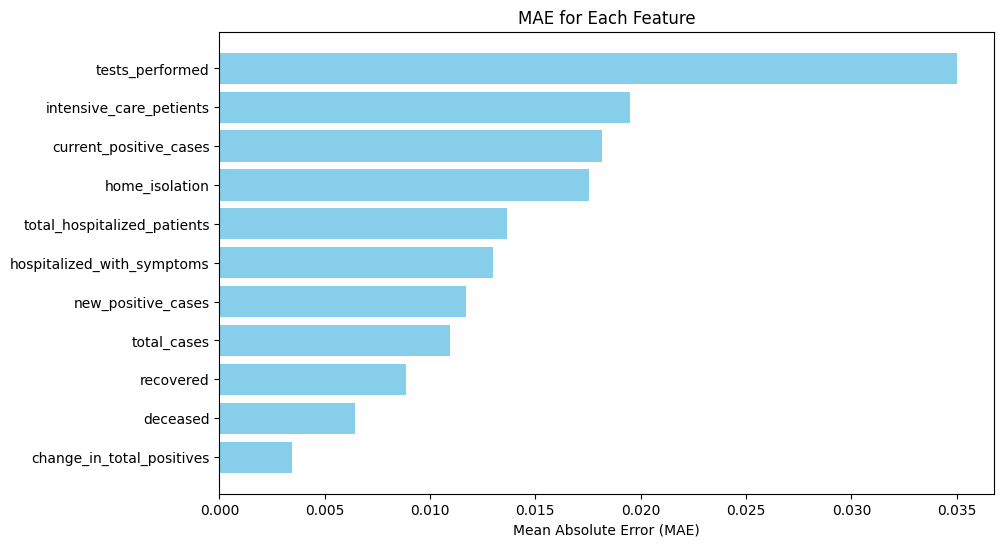

In [ ]:
# Print the MAE for each feature
print("Mean Absolute Error (MAE) for Each Feature:")
mae_feature_pairs = [(mae_value, feature_name) for mae_value, feature_name in zip(mae, column_names)]

# Sort the MAE-feature pairs by MAE values
mae_feature_pairs.sort()

# Separate sorted MAE values and feature names
sorted_mae, sorted_features = zip(*mae_feature_pairs)

# Plot the MAE values
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_mae, color='skyblue')
plt.xlabel('Mean Absolute Error (MAE)')
plt.title('MAE for Each Feature')
plt.show()

In [ ]:
print(reconstructed_data)

[[0.01213407 0.01734631 0.01271905 ... 0.0026717  0.01289805 0.02699853]
 [0.01213401 0.01734631 0.01271899 ... 0.00267163 0.01289777 0.02699789]
 [0.01213403 0.0173463  0.01271901 ... 0.00267164 0.01289782 0.02699801]
 ...
 [0.01921996 0.02379719 0.02064241 ... 0.00797423 0.0310633  0.06354125]
 [0.03145748 0.03366463 0.03363638 ... 0.02543423 0.07619358 0.1457668 ]
 [0.01309927 0.01765135 0.0139111  ... 0.00387082 0.01763428 0.03833135]]


In [ ]:
reconstructed_df = pd.DataFrame(reconstructed_data, columns=autoencoder_columns)
reconstructed_df

,hospitalized_with_symptoms,intensive_care_petients,total_hospitalized_patients,home_isolation,current_positive_cases,change_in_total_positives,new_positive_cases,recovered,deceased,total_cases,tests_performed
0,0.012134,0.017346,0.012719,0.019005,0.020002,0.734606,0.018306,0.006099,0.002672,0.012898,0.026999
1,0.012134,0.017346,0.012719,0.019005,0.020002,0.734606,0.018306,0.006099,0.002672,0.012898,0.026998
2,0.012134,0.017346,0.012719,0.019005,0.020002,0.734606,0.018306,0.006099,0.002672,0.012898,0.026998
3,0.012134,0.017346,0.012719,0.019006,0.020002,0.734605,0.018306,0.006099,0.002672,0.012898,0.026999
4,0.012205,0.017445,0.012790,0.019058,0.020074,0.734703,0.018386,0.006115,0.002683,0.012938,0.027022
...,...,...,...,...,...,...,...,...,...,...,...
979,0.020850,0.026083,0.022275,0.042344,0.042061,0.717345,0.023850,0.017142,0.008332,0.031587,0.062093
980,0.014081,0.019154,0.014852,0.025026,0.025527,0.728044,0.019264,0.008770,0.003910,0.017560,0.036658
981,0.019220,0.023797,0.020642,0.041324,0.040423,0.715980,0.022056,0.017146,0.007974,0.031063,0.063541
982,0.031457,0.033665,0.033636,0.090175,0.080629,0.699379,0.027650,0.050224,0.025434,0.076194,0.145767


In [ ]:
test_data_df = pd.DataFrame(test_data, columns=autoencoder_columns)
test_data_df

,hospitalized_with_symptoms,intensive_care_petients,total_hospitalized_patients,home_isolation,current_positive_cases,change_in_total_positives,new_positive_cases,recovered,deceased,total_cases,tests_performed
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.732474,0.005506,0.000000,0.000000,0.000000,0.000009
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.732474,0.005506,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.732474,0.005506,0.000000,0.000000,0.000000,0.000002
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.732474,0.005506,0.000000,0.000000,0.000000,0.000018
4,0.000083,0.000724,0.000150,0.000000,0.000054,0.732474,0.006118,0.000024,0.000000,0.000036,0.000225
...,...,...,...,...,...,...,...,...,...,...,...
979,0.023599,0.016655,0.023109,0.061648,0.058461,0.722596,0.008259,0.042088,0.029914,0.051903,0.159314
980,0.006210,0.007241,0.006378,0.012376,0.012357,0.731925,0.006424,0.018603,0.008111,0.016025,0.072390
981,0.016395,0.007965,0.015681,0.051050,0.047176,0.719577,0.007954,0.032982,0.017066,0.040110,0.205174
982,0.019707,0.048516,0.022884,0.094233,0.084917,0.702291,0.012848,0.140105,0.063331,0.117488,0.358581


In [ ]:
print(covid_ds.Date)
print(covid_ds.Region_code)

0      2020-02-24 18:00:00
1      2020-02-24 18:00:00
2      2020-02-24 18:00:00
3      2020-02-24 18:00:00
4      2020-02-24 18:00:00
               ...        
1717   2020-05-15 17:00:00
1718   2020-05-15 17:00:00
1719   2020-05-15 17:00:00
1720   2020-05-15 17:00:00
1721   2020-05-15 17:00:00
Name: Date, Length: 1722, dtype: datetime64[ns]
0       13
1       17
2       18
3       15
4        8
        ..
1717    19
1718     9
1719    10
1720     2
1721     5
Name: Region_code, Length: 1722, dtype: int64


In [ ]:
# Calculate differences between original and reconstructed values for each value and feature (cambia daily)
daily_differences = np.abs(test_data - reconstructed_data)

# Calculate the mean difference for each feature
mean_daily_difference = np.mean(daily_differences, axis=0)

# Print or visualize the mean difference for each feature
print("Mean Difference for Each Feature:")
for i, mean_diff_value in enumerate(mean_daily_difference):
    print(f"Feature {i}: {mean_diff_value}")

# Calculate the threshold as a percentile of mean differences
threshold = np.percentile(mean_daily_difference, 80)

# Identify features with mean differences exceeding the threshold
difficult_features = [i for i, mean_diff_value in enumerate(mean_daily_difference) if mean_diff_value > threshold]

# Print or visualize the difficult features
print("Features with Mean Difference exceeding the threshold:")
for feature_index in difficult_features:
    print(f"Feature {feature_index}: Mean Diff = {mean_daily_difference[feature_index]}")

# Additional analysis based on overall differences
total_differences = np.sum(daily_differences, axis=0)

# Display the results in a DataFrame
result_df = pd.DataFrame({
    'Feature': autoencoder_columns,
    'Mean_Difference': mean_daily_difference,
    'Total_Difference': total_differences
})

print(result_df)


Mean Difference for Each Feature:
Feature 0: 0.013012117431682499
Feature 1: 0.01951595042916781
Feature 2: 0.013634162000304121
Feature 3: 0.01755556735300219
Feature 4: 0.0181656821381779
Feature 5: 0.0034519508112048074
Feature 6: 0.01171276890746411
Feature 7: 0.008847625272407691
Feature 8: 0.006441704286918445
Feature 9: 0.010952531040523935
Feature 10: 0.035036309124760155
Features with Mean Difference exceeding the threshold:
Feature 1: Mean Diff = 0.01951595042916781
Feature 10: Mean Diff = 0.035036309124760155
                        Feature  Mean_Difference  Total_Difference
0    hospitalized_with_symptoms         0.013012         12.803924
1       intensive_care_petients         0.019516         19.203695
2   total_hospitalized_patients         0.013634         13.416015
3                home_isolation         0.017556         17.274678
4        current_positive_cases         0.018166         17.875031
5     change_in_total_positives         0.003452          3.396720
6    

In [ ]:

# Calculate differences between original and reconstructed values for each value and feature
daily_differences = np.abs(test_data - reconstructed_data)

# Define the percentile for the threshold
percentile_threshold = 95

# Calculate the threshold as a percentile of differences
threshold = np.percentile(daily_differences, percentile_threshold)

# Count the number of values exceeding the threshold for each column
values_exceeding_threshold = np.sum(daily_differences > threshold, axis=0)

# Display the count of values exceeding the threshold for each column
print(f"Number of Values Exceeding {percentile_threshold}th Percentile Threshold for Each Column:")
for i, count in enumerate(values_exceeding_threshold):
    print(f"Column {i}: {count} values exceed the threshold")

# Additional analysis based on overall differences
total_differences = np.sum(daily_differences, axis=0)

# Display the results in a DataFrame
result_df = pd.DataFrame({
    'Feature': autoencoder_columns,
    'Total_Difference': total_differences
})

print(result_df)


Number of Values Exceeding 95th Percentile Threshold for Each Column:
Column 0: 51 values exceed the threshold
Column 1: 118 values exceed the threshold
Column 2: 52 values exceed the threshold
Column 3: 48 values exceed the threshold
Column 4: 32 values exceed the threshold
Column 5: 1 values exceed the threshold
Column 6: 6 values exceed the threshold
Column 7: 13 values exceed the threshold
Column 8: 27 values exceed the threshold
Column 9: 5 values exceed the threshold
Column 10: 189 values exceed the threshold
                        Feature  Total_Difference
0    hospitalized_with_symptoms         12.803924
1       intensive_care_petients         19.203695
2   total_hospitalized_patients         13.416015
3                home_isolation         17.274678
4        current_positive_cases         17.875031
5     change_in_total_positives          3.396720
6            new_positive_cases         11.525365
7                     recovered          8.706063
8                      deceas

In [ ]:
print(test_data)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.08421980e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.81684396e-06]
 ...
 [1.63948000e-02 7.96524258e-03 1.56812725e-02 ... 1.70657323e-02
  4.01098444e-02 2.05174372e-01]
 [1.97068808e-02 4.85155684e-02 2.28841537e-02 ... 6.33313867e-02
  1.17488320e-01 3.58581408e-01]
 [2.07005051e-03 1.44822592e-03 2.02581032e-03 ... 4.73687626e-03
  1.69046232e-02 9.77480219e-02]]


In [ ]:
# Extract the region codes for the regions in test_data
test_region_codes = other_regions_data['Region_code'].values

# Find the indexes of these region codes in the original dataset
original_indexes = covid_ds[covid_ds['Region_code'].isin(test_region_codes)].index

# Print the original indexes
print("Original Indexes of Test Regions:", original_indexes)


Original Indexes of Test Regions: Int64Index([   0,    1,    2,    3,    6,    9,   10,   14,   15,   16,
            ...
            1703, 1704, 1707, 1710, 1711, 1715, 1716, 1717, 1718, 1719],
           dtype='int64', length=984)


In [ ]:
# Extract the region codes for the regions in test_data
test_region_codes = other_regions_data['Region_code'].values

# Find the indexes of these region codes in the original dataset
original_indexes = covid_ds[covid_ds['Region_code'].isin(test_region_codes)].index

# Create datasets with Date and Region_code values added
test_data_with_dates = other_regions_data.loc[other_regions_data.index.isin(original_indexes), autoencoder_columns + ['Date', 'Region_code']].copy()
reconstructed_data_with_dates = pd.DataFrame(reconstructed_data, columns=autoencoder_columns)

print(len(reconstructed_data_with_dates))

# Add Date values to the datasets using the original indexes
test_data_with_dates['Date'] = covid_ds.loc[original_indexes, 'Date'].values
reconstructed_data_with_dates['Date'] = covid_ds.loc[original_indexes, 'Date'].values

# Add Region_code values to the datasets using the original indexes
test_data_with_dates['Region_code'] = covid_ds.loc[original_indexes, 'Region_code'].values
reconstructed_data_with_dates['Region_code'] = covid_ds.loc[original_indexes, 'Region_code'].values

# Print or use the datasets as needed
print("Test Data with Dates and Region_code:")
print(test_data_with_dates)

print("\nReconstructed Data with Dates and Region_code:")
print(reconstructed_data_with_dates)


984
Test Data with Dates and Region_code:
      hospitalized_with_symptoms  intensive_care_petients  \
0                       0.000000                 0.000000   
1                       0.000000                 0.000000   
2                       0.000000                 0.000000   
3                       0.000000                 0.000000   
6                       0.000083                 0.000724   
...                          ...                      ...   
1715                    0.023599                 0.016655   
1716                    0.006210                 0.007241   
1717                    0.016395                 0.007965   
1718                    0.019707                 0.048516   
1719                    0.002070                 0.001448   

      total_hospitalized_patients  home_isolation  current_positive_cases  \
0                        0.000000        0.000000                0.000000   
1                        0.000000        0.000000                0.0000

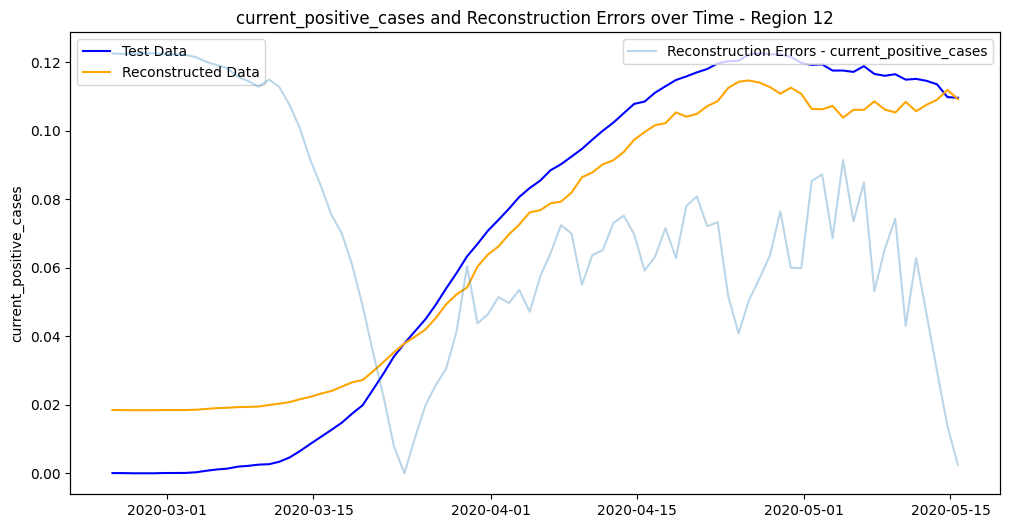

In [ ]:
# Choose the region code to focus on
region_code_to_plot = 12

# Filter the datasets for the specific region
test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

# Specify the columns to plot
columns_to_plot = ['current_positive_cases']

# Create a figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot original and reconstructed data
ax1.plot(test_data_region['Date'], test_data_region[columns_to_plot[0]], label='Test Data', linestyle='-', color='blue')
ax1.plot(reconstructed_data_region['Date'], reconstructed_data_region[columns_to_plot[0]], label='Reconstructed Data', linestyle='-', color='orange')
ax1.set_ylabel(columns_to_plot[0])
ax1.legend(loc='upper left')

# Calculate reconstruction errors for each date
reconstruction_errors = np.abs(test_data_region[columns_to_plot[0]].values - reconstructed_data_region[columns_to_plot[0]].values)

# Create a secondary y-axis for reconstruction errors
ax2 = ax1.twinx()
ax2.plot(test_data_region['Date'], reconstruction_errors, label=f'Reconstruction Errors - {columns_to_plot[0]}', linestyle='-', alpha=0.3)
ax2.set_yticks([])  # Hide y-axis ticks for reconstruction errors
ax2.legend(loc='upper right')

plt.title(f'{columns_to_plot[0]} and Reconstruction Errors over Time - Region {region_code_to_plot}')
plt.xticks(rotation=45)
plt.show()


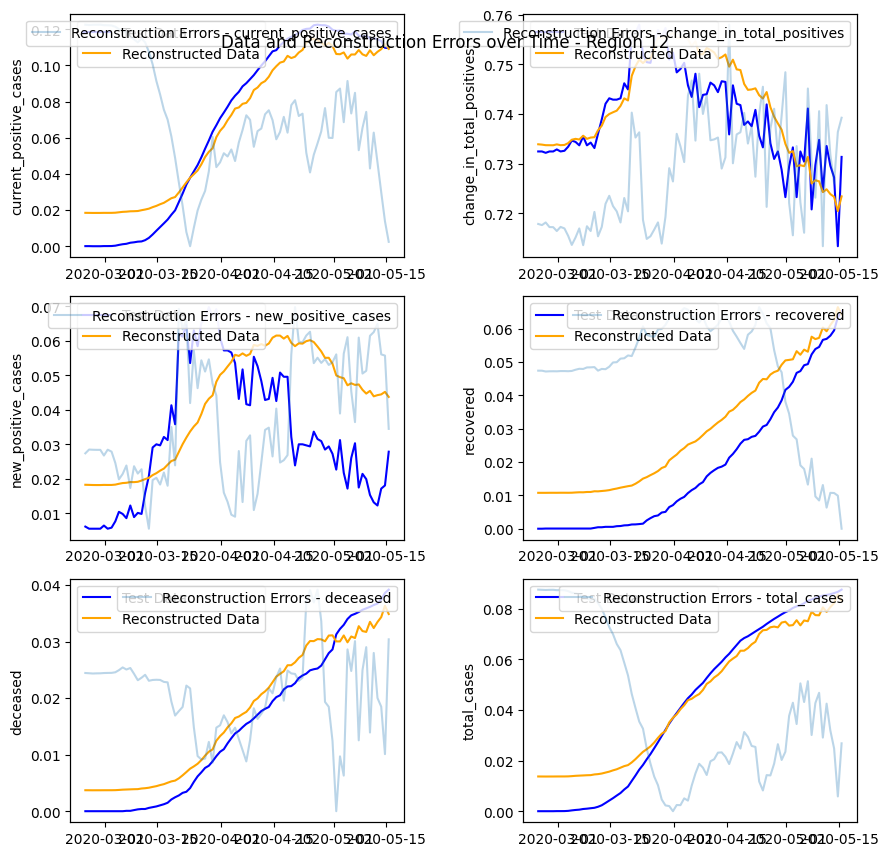

In [ ]:
import matplotlib.dates as mdates
# Choose the region code to focus on
region_code_to_plot = 12

# Filter the datasets for the specific region
test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

# Specify the columns to plot
columns_to_plot = ['current_positive_cases', 'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases']
# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate over each column and subplot
for i, column in enumerate(columns_to_plot):
    # Plot original and reconstructed data
    axes[i].plot(test_data_region['Date'], test_data_region[column], label='Test Data', linestyle='-', color='blue')
    axes[i].plot(reconstructed_data_region['Date'], reconstructed_data_region[column], label='Reconstructed Data', linestyle='-', color='orange')
    axes[i].set_ylabel(column)
    axes[i].legend(loc='upper left')

    # Calculate reconstruction errors for the specific column
    reconstruction_errors = np.abs(test_data_region[column].values - reconstructed_data_region[column].values)

    # Create a secondary y-axis for reconstruction errors
    ax2 = axes[i].twinx()
    ax2.plot(mdates.date2num(test_data_region['Date']), reconstruction_errors, label=f'Reconstruction Errors - {column}', linestyle='-', alpha=0.3)
    ax2.set_yticks([])  # Hide y-axis ticks for reconstruction errors
    ax2.legend(loc='upper right')

# Remove empty subplots
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Data and Reconstruction Errors over Time - Region {region_code_to_plot}', y=0.92)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


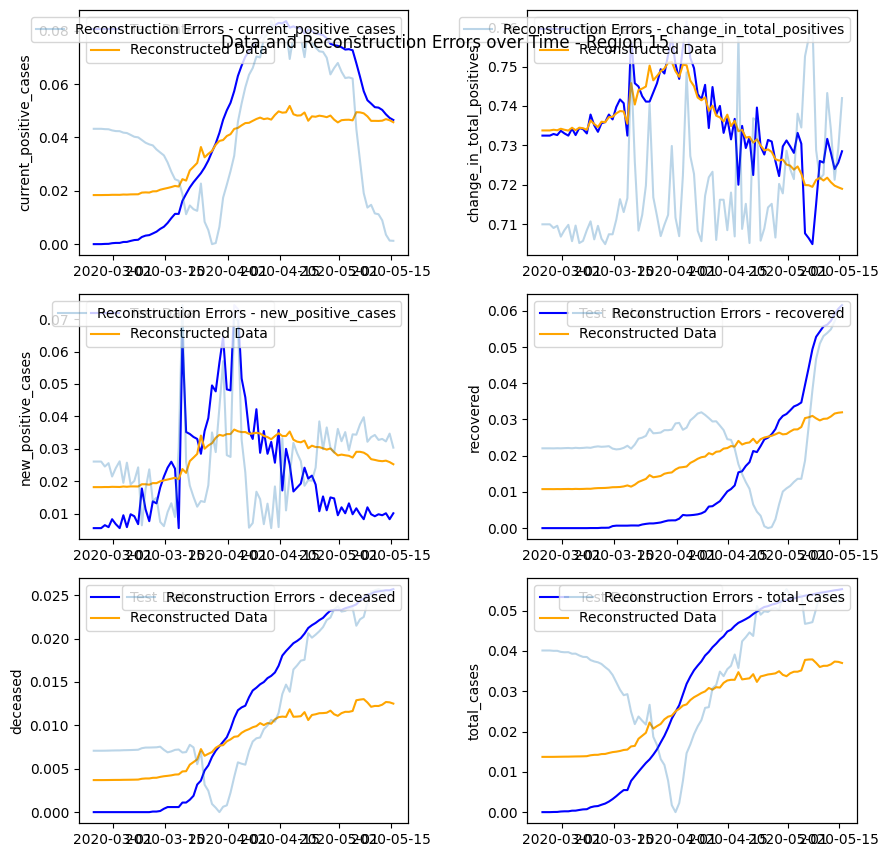

In [ ]:

# Choose the region code to focus on
region_code_to_plot = 15

# Filter the datasets for the specific region
test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

# Specify the columns to plot
columns_to_plot = ['current_positive_cases', 'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate over each column and subplot
for i, column in enumerate(columns_to_plot):
    # Plot original and reconstructed data
    axes[i].plot(test_data_region['Date'], test_data_region[column], label='Test Data', linestyle='-', color='blue')
    axes[i].plot(reconstructed_data_region['Date'], reconstructed_data_region[column], label='Reconstructed Data', linestyle='-', color='orange')
    axes[i].set_ylabel(column)
    axes[i].legend(loc='upper left')

    # Calculate reconstruction errors for the specific column
    reconstruction_errors = np.abs(test_data_region[column].values - reconstructed_data_region[column].values)

    # Create a secondary y-axis for reconstruction errors
    ax2 = axes[i].twinx()
    ax2.plot(mdates.date2num(test_data_region['Date']), reconstruction_errors, label=f'Reconstruction Errors - {column}', linestyle='-', alpha=0.3)
    ax2.set_yticks([])  # Hide y-axis ticks for reconstruction errors
    ax2.legend(loc='upper right')

# Remove empty subplots
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Data and Reconstruction Errors over Time - Region {region_code_to_plot}', y=0.92)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


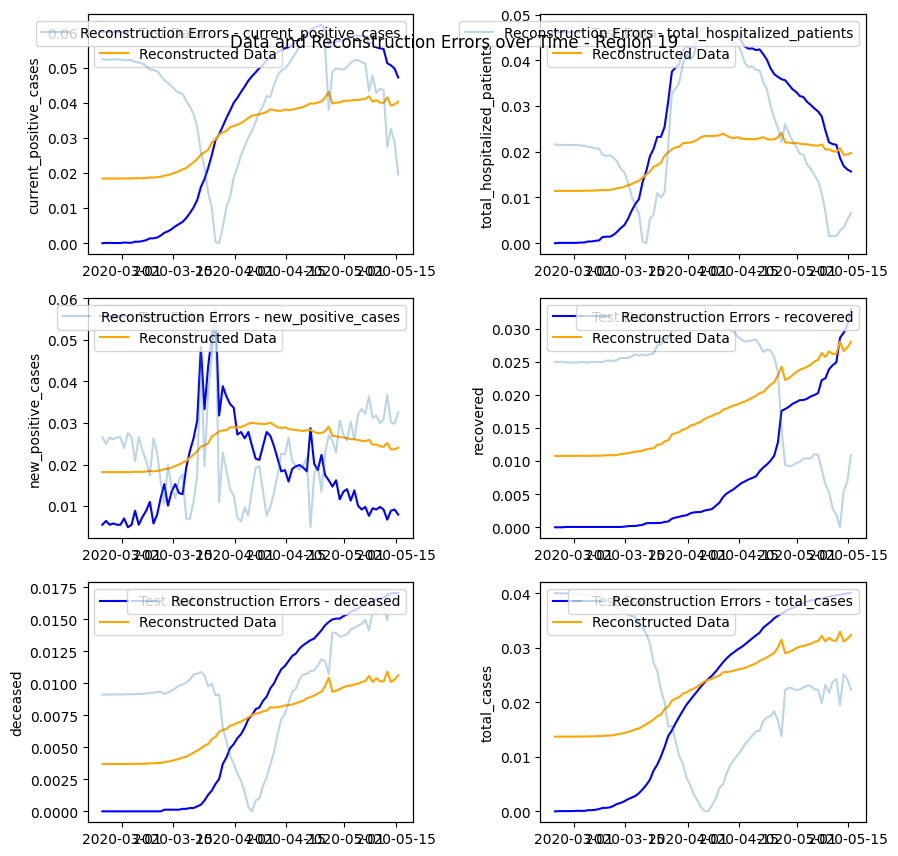

In [ ]:
import matplotlib.dates as mdates
# Choose the region code to focus on
region_code_to_plot = 19

# Filter the datasets for the specific region
test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

# Specify the columns to plot
columns_to_plot = ['current_positive_cases', 'total_hospitalized_patients', 'new_positive_cases', 'recovered', 'deceased', 'total_cases']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate over each column and subplot
for i, column in enumerate(columns_to_plot):
    # Plot original and reconstructed data
    axes[i].plot(test_data_region['Date'], test_data_region[column], label='Test Data', linestyle='-', color='blue')
    axes[i].plot(reconstructed_data_region['Date'], reconstructed_data_region[column], label='Reconstructed Data', linestyle='-', color='orange')
    axes[i].set_ylabel(column)
    axes[i].legend(loc='upper left')

    # Calculate reconstruction errors for the specific column
    reconstruction_errors = np.abs(test_data_region[column].values - reconstructed_data_region[column].values)

    # Create a secondary y-axis for reconstruction errors
    ax2 = axes[i].twinx()
    ax2.plot(mdates.date2num(test_data_region['Date']), reconstruction_errors, label=f'Reconstruction Errors - {column}', linestyle='-', alpha=0.3)
    ax2.set_yticks([])  # Hide y-axis ticks for reconstruction errors
    ax2.legend(loc='upper right')

# Remove empty subplots
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Data and Reconstruction Errors over Time - Region {region_code_to_plot}', y=0.92)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Y-Axis Limits: (0.0, 1.0)


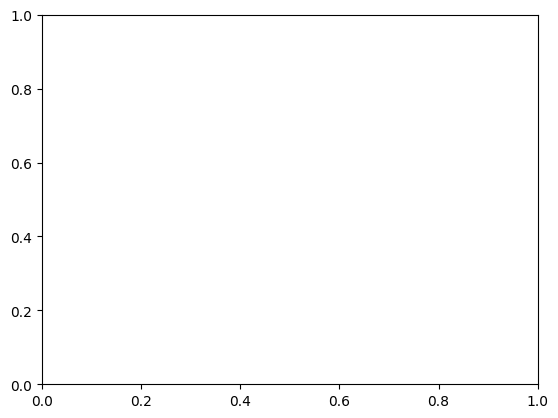

In [ ]:
# Get the current y-axis limits
y_limits = plt.ylim()

# Print the y-axis limits
print("Y-Axis Limits:", y_limits)

# Show the plot
plt.show()

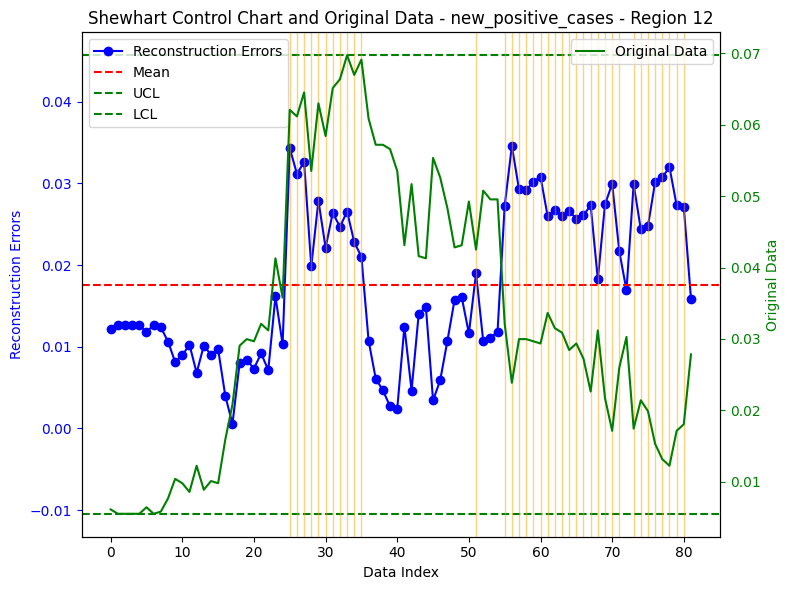

In [ ]:
#LAZIO
# Choose the region code to focus on
region_code_to_plot = 12

# Filter the datasets for the specific region
test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

# Specify the column to plot
column_to_plot = 'new_positive_cases'

# Calculate reconstruction errors for the specific column
reconstruction_errors = np.abs(test_data_region[column_to_plot].values - reconstructed_data_region[column_to_plot].values)

# Calculate mean and standard deviation of reconstruction errors
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

# Set control limits
UCL = mean_error + 3 * std_error
LCL = mean_error - 3 * std_error


original_data = test_data_region['new_positive_cases'].values

# Create a Shewhart Control Chart with vertical lines and original data
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Shewhart Control Chart
ax1.plot(range(len(reconstruction_errors)), reconstruction_errors, linestyle='-', marker='o', color='blue', label='Reconstruction Errors')
ax1.axhline(y=mean_error, color='red', linestyle='--', label='Mean')
ax1.axhline(y=UCL, color='green', linestyle='--', label='UCL')
ax1.axhline(y=LCL, color='green', linestyle='--', label='LCL')

# Highlight points above the mean with a different color
for i, error in enumerate(reconstruction_errors):
    if error > mean_error and error <= UCL:
        ax1.axvline(x=i, color='orange', linestyle='-', linewidth=1, alpha=0.5)  # Points above mean but within UCL in orange

ax1.set_xlabel('Data Index')
ax1.set_ylabel('Reconstruction Errors', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='upper left')

# Create a second y-axis for original data
ax2 = ax1.twinx()
ax2.plot(range(len(original_data)), original_data, linestyle='-', color='green', label='Original Data')
ax2.set_ylabel('Original Data', color='green')
ax2.tick_params('y', colors='green')
ax2.legend(loc='upper right')

plt.title(f'Shewhart Control Chart and Original Data - {column_to_plot} - Region {region_code_to_plot}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


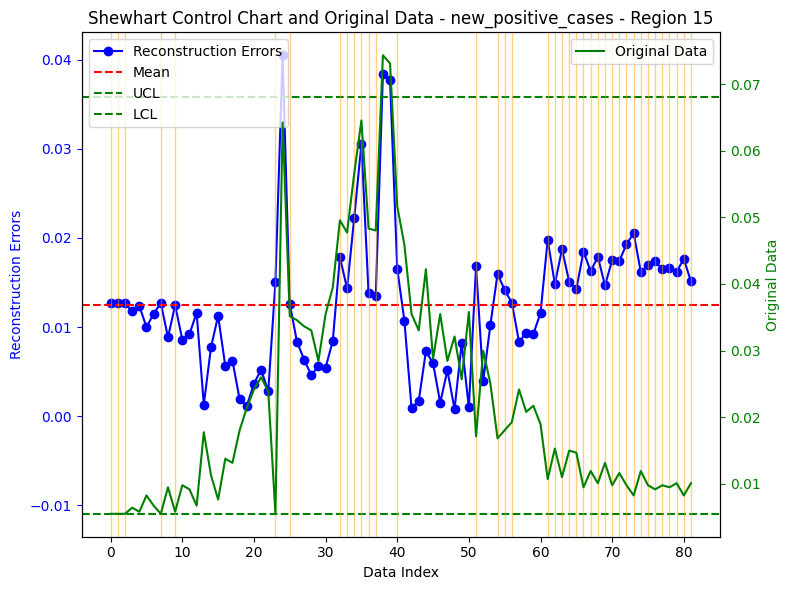

In [ ]:
#CAMPANIA
# Choose the region code to focus on
region_code_to_plot = 15

# Filter the datasets for the specific region
test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

# Specify the column to plot
column_to_plot = 'new_positive_cases'

# Calculate reconstruction errors for the specific column
reconstruction_errors = np.abs(test_data_region[column_to_plot].values - reconstructed_data_region[column_to_plot].values)

# Calculate mean and standard deviation of reconstruction errors
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

# Set control limits
UCL = mean_error + 3 * std_error
LCL = mean_error - 3 * std_error

original_data = test_data_region['new_positive_cases'].values

# Create a Shewhart Control Chart with vertical lines and original data
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Shewhart Control Chart
ax1.plot(range(len(reconstruction_errors)), reconstruction_errors, linestyle='-', marker='o', color='blue', label='Reconstruction Errors')
ax1.axhline(y=mean_error, color='red', linestyle='--', label='Mean')
ax1.axhline(y=UCL, color='green', linestyle='--', label='UCL')
ax1.axhline(y=LCL, color='green', linestyle='--', label='LCL')

# Highlight points above the mean with a different color
for i, error in enumerate(reconstruction_errors):
    if error > mean_error and error <= UCL:
        ax1.axvline(x=i, color='orange', linestyle='-', linewidth=1, alpha=0.5)  # Points above mean but within UCL in orange

ax1.set_xlabel('Data Index')
ax1.set_ylabel('Reconstruction Errors', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='upper left')

# Create a second y-axis for original data
ax2 = ax1.twinx()
ax2.plot(range(len(original_data)), original_data, linestyle='-', color='green', label='Original Data')
ax2.set_ylabel('Original Data', color='green')
ax2.tick_params('y', colors='green')
ax2.legend(loc='upper right')

plt.title(f'Shewhart Control Chart and Original Data - {column_to_plot} - Region {region_code_to_plot}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


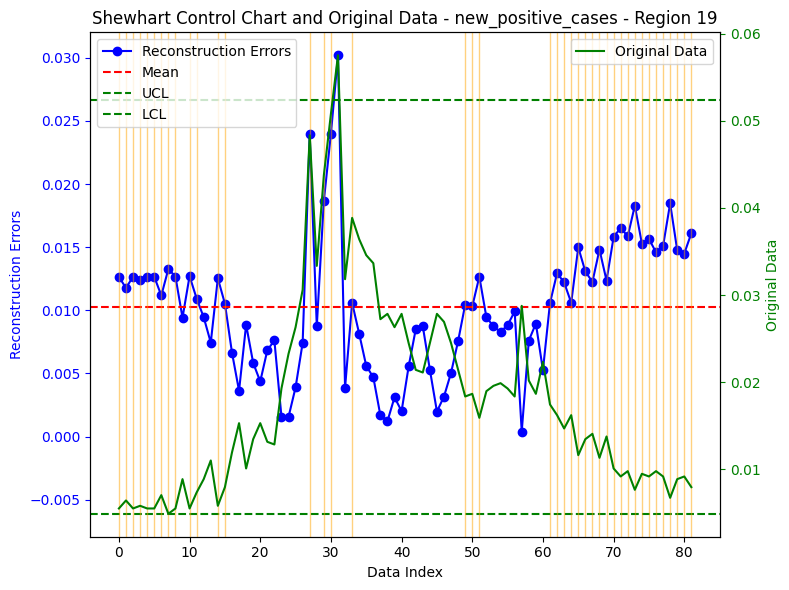

In [ ]:
#SICILIA
# Choose the region code to focus on
region_code_to_plot = 19

# Filter the datasets for the specific region
test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

# Specify the column to plot
column_to_plot = 'new_positive_cases'

# Calculate reconstruction errors for the specific column
reconstruction_errors = np.abs(test_data_region[column_to_plot].values - reconstructed_data_region[column_to_plot].values)

# Calculate mean and standard deviation of reconstruction errors
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

# Set control limits
UCL = mean_error + 3 * std_error
LCL = mean_error - 3 * std_error


original_data = test_data_region['new_positive_cases'].values

# Create a Shewhart Control Chart with vertical lines and original data
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Shewhart Control Chart
ax1.plot(range(len(reconstruction_errors)), reconstruction_errors, linestyle='-', marker='o', color='blue', label='Reconstruction Errors')
ax1.axhline(y=mean_error, color='red', linestyle='--', label='Mean')
ax1.axhline(y=UCL, color='green', linestyle='--', label='UCL')
ax1.axhline(y=LCL, color='green', linestyle='--', label='LCL')

# Highlight points above the mean with a different color
for i, error in enumerate(reconstruction_errors):
    if error > mean_error and error <= UCL:
        ax1.axvline(x=i, color='orange', linestyle='-', linewidth=1, alpha=0.5)  # Points above mean but within UCL in orange

ax1.set_xlabel('Data Index')
ax1.set_ylabel('Reconstruction Errors', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='upper left')

# Create a second y-axis for original data
ax2 = ax1.twinx()
ax2.plot(range(len(original_data)), original_data, linestyle='-', color='green', label='Original Data')
ax2.set_ylabel('Original Data', color='green')
ax2.tick_params('y', colors='green')
ax2.legend(loc='upper right')

plt.title(f'Shewhart Control Chart and Original Data - {column_to_plot} - Region {region_code_to_plot}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
